In [1]:
import torch
import os
from sklearn.metrics import precision_recall_curve,auc,roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
from pylab import rcParams
from PIL import Image

In [2]:
model_dir="runtime-model-50epochs-b64-expdecay-reverseKL"
batch_size=64
n_in=28
num_channels=1
data_dir="./runtime-data"
in_dataset="MNIST"

## Only In domain dataset evaluation

In [2]:
out_dir=model_dir+"/eval"

In [3]:
cmd = f"python ./priornet/run/eval_ID.py --batch_size {batch_size} --gpu -1 --model_dir {model_dir} --n_channels {num_channels} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python ./priornet/run/eval_ID.py --batch_size 64 --gpu -1 --model_dir runtime-model-50epochs-b64-expdecay --n_channels 1 ./runtime-data MNIST runtime-model-50epochs-b64-expdecay/eval


In [4]:
os.system(cmd)

0

## Both In-domain and OOD dataset evaluation

In [2]:
ood_dataset="OMNIGLOT"
out_dir=model_dir+"/ood-eval"

In [6]:
cmd = f"python ./priornet/run/ood_detect.py --batch_size {batch_size} --gpu -1 --model_dir {model_dir} --n_channels {num_channels} {data_dir} {in_dataset} {ood_dataset} {out_dir}"
print(cmd)

python ./priornet/run/ood_detect.py --batch_size 64 --gpu -1 --model_dir runtime-model-50epochs-b64-expdecay --n_channels 1 ./runtime-data MNIST OMNIGLOT runtime-model-50epochs-b64-expdecay/ood-eval


In [7]:
os.system(cmd)

0

## General utils

In [3]:
def plot_curve(x, y, axes, row_index, col_index, x_label='',y_label='', title=''):
    if axes.ndim == 2:
        axis = axes[row_index][col_index]
    else:
        axis = axes[row_index+col_index]
    right_side = axis.spines["right"]
    right_side.set_visible(False)
    top_side = axis.spines["top"]
    top_side.set_visible(False)
    
    axis.set_title("\n".join(wrap(title, 20)))
    axis.plot(x, y)
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    axis.set_ylim(0.00, 1.00)
    axis.set_xlim(0.00, 1.00)

In [4]:
def plot_aupr_auroc(aupr_list, auroc_list):
    print("AU_PR: ", aupr_list)
    print("AU_ROC: ", auroc_list)
    x = np.arange(len(aupr_list)) 
    width = 0.35
    auprs = [np.round(x * 100.0, 1) for x in aupr_list]
    aurocs = [np.round(x * 100.0, 1) for x in auroc_list]

    rcParams['figure.figsize'] = 5, 5
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, auprs, width, label='AU_PR')
    rects2 = ax.bar(x + width/2, aurocs, width, label='AU_ROC')

    ax.set_ylabel('AC')
    ax.set_title('AC by different models')
    ax.set_xticks(x)
    ax.set_xticklabels([f'model{i}' for i in range(len(aupr_list))])
    ax.legend()

    fig.tight_layout()
    plt.show()

In [5]:
models = ["runtime-model-50epochs-b128-expdecay-reverseKL", "runtime-model-50epochs-b64-expdecay-reverseKL", "runtime-model-50epochs-b64-expdecay"]

## OOD Detection - confidence

In [6]:
def plot_pr_roc_curve_ood(models, eval_dir, eval_measure):
    aupr_list = []
    auroc_list = []
    rcParams['figure.figsize'] = 15, 10
    figure, axes = plt.subplots(nrows=2, ncols=len(models))
    for i in range(len(models)):
        model_dir = models[i]
        print(f"eval model: {model_dir}")
        id_conf = f"{model_dir}/{eval_dir}/{eval_measure}_id.txt"
        ood_conf = f"{model_dir}/{eval_dir}/{eval_measure}_ood.txt"

        confidence_id = np.loadtxt(id_conf)
        confidence_ood = np.loadtxt(ood_conf)

        # append both type of samples
        scores = np.concatenate((confidence_id, confidence_ood), axis=0)
        scores = np.asarray(scores, dtype=np.float128)
        if eval_measure == 'confidence':
            # negation of confidence is the measure for detecting OOD, ID samples have higher confidence than OOD samples.
            scores *= -1.0
    
        # OOD detection is a Bianry classification task
        truth_labels = np.concatenate((np.zeros_like(confidence_id), np.ones_like(confidence_ood)), axis=0)

        precision, recall, thresholds = precision_recall_curve(truth_labels, scores)
        plot_curve(recall, precision, axes, 0, i, 'Recall', 'Precision', models[i])
        aupr = auc(recall, precision)
        aupr_list.append(aupr)

        fpr, tpr, thresholds = roc_curve(truth_labels, scores)
        plot_curve(fpr, tpr, axes, 1, i, 'False Positive', 'True Positive', models[i])
        roc_auc = roc_auc_score(truth_labels, scores)
        auroc_list.append(roc_auc)

    figure.tight_layout(pad=2)
    plt.show()
    return aupr_list,auroc_list

eval model: runtime-model-50epochs-b128-expdecay-reverseKL
eval model: runtime-model-50epochs-b64-expdecay-reverseKL
eval model: runtime-model-50epochs-b64-expdecay


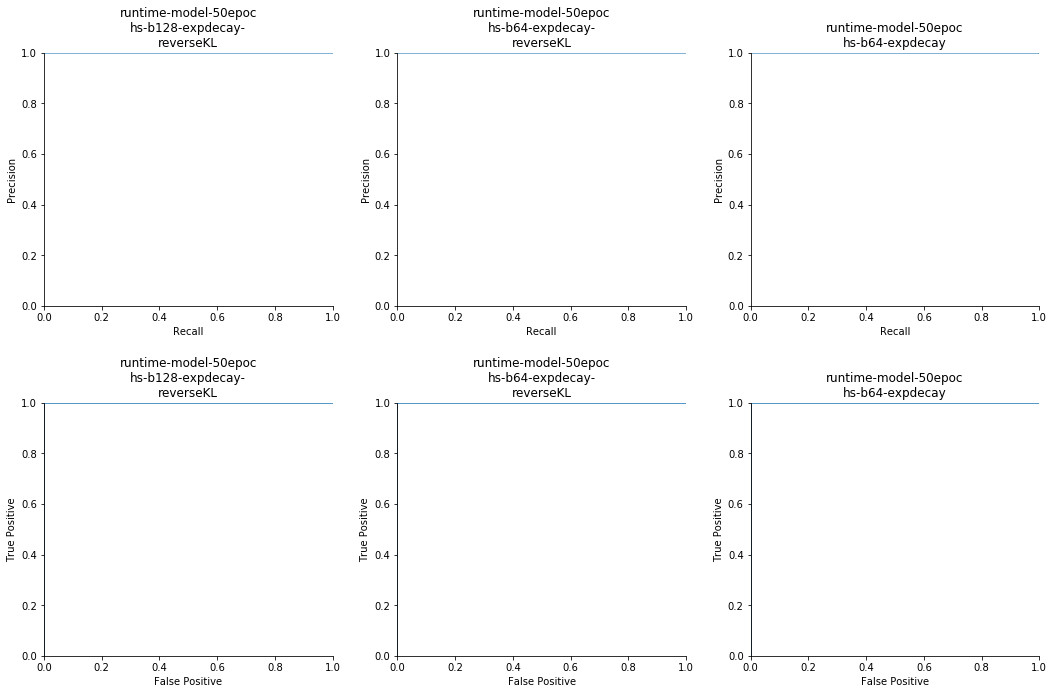

AU_PR:  [1.0, 1.0, 0.9999997469054296]
AU_ROC:  [1.0, 1.0, 0.9999996661608498]


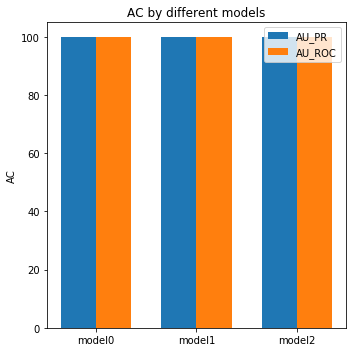

In [7]:
aupr_list, auroc_list = plot_pr_roc_curve_ood(models, 'ood-eval', 'confidence')
plot_aupr_auroc(aupr_list, auroc_list)

## Misclassification Detection - confidence

In [34]:
def plot_pr_roc_curve_misclassify(models, eval_dir, eval_measure, fig_size=(15,10), subset_indices=[]):
    aupr_list = []
    auroc_list = []
    class_dist = []
    rcParams['figure.figsize'] = fig_size
    figure, axes = plt.subplots(nrows=2, ncols=len(models))
    for i in range(len(models)):
        model_dir = models[i]
        print(f"eval model: {model_dir}")
        evalmeasure = f"{model_dir}/{eval_dir}/{eval_measure}.txt"

        measure = np.loadtxt(evalmeasure)

        scores = measure 
        if eval_measure == 'confidence':
            # negation needed for confidence, as confidence is indicator of -ve samples for correct classified samples
            # we need scores for misclassified samples to be higher, so we negate.
            scores *= -1.0
        
        # Misclassification is a Binary classification task
        probs = np.loadtxt(f"{model_dir}/{eval_dir}/probs.txt")
        labels = np.loadtxt(f"{model_dir}/{eval_dir}/labels.txt")
        class_preds = np.argmax(probs, axis=1)
        
        if len(subset_indices) > 0:
            scores = scores[subset_indices]
            labels = labels[subset_indices]
            class_preds = class_preds[subset_indices]

        truth_labels = np.asarray(labels != class_preds, dtype=np.int32)

        precision, recall, thresholds = precision_recall_curve(truth_labels, scores)
        plot_curve(recall, precision, axes, 0, i, 'Recall', 'Precision', models[i])
        aupr = auc(recall, precision)
        aupr_list.append(aupr)

        fpr, tpr, thresholds = roc_curve(truth_labels, scores)
        plot_curve(fpr, tpr, axes, 1, i, 'False Positive', 'True Positive', models[i])
        roc_auc = roc_auc_score(truth_labels, scores)
        auroc_list.append(roc_auc)
        # also return class distribution
        pos_cnt = len(truth_labels[truth_labels == 1]) # misclassifications
        neg_cnt = len(truth_labels[truth_labels == 0]) # correct classifications
        class_dist.append([pos_cnt, neg_cnt])

    figure.tight_layout(pad=2)
    plt.show()
    
    
    return aupr_list,auroc_list,class_dist

eval model: runtime-model-50epochs-b128-expdecay-reverseKL
eval model: runtime-model-50epochs-b64-expdecay-reverseKL
eval model: runtime-model-50epochs-b64-expdecay


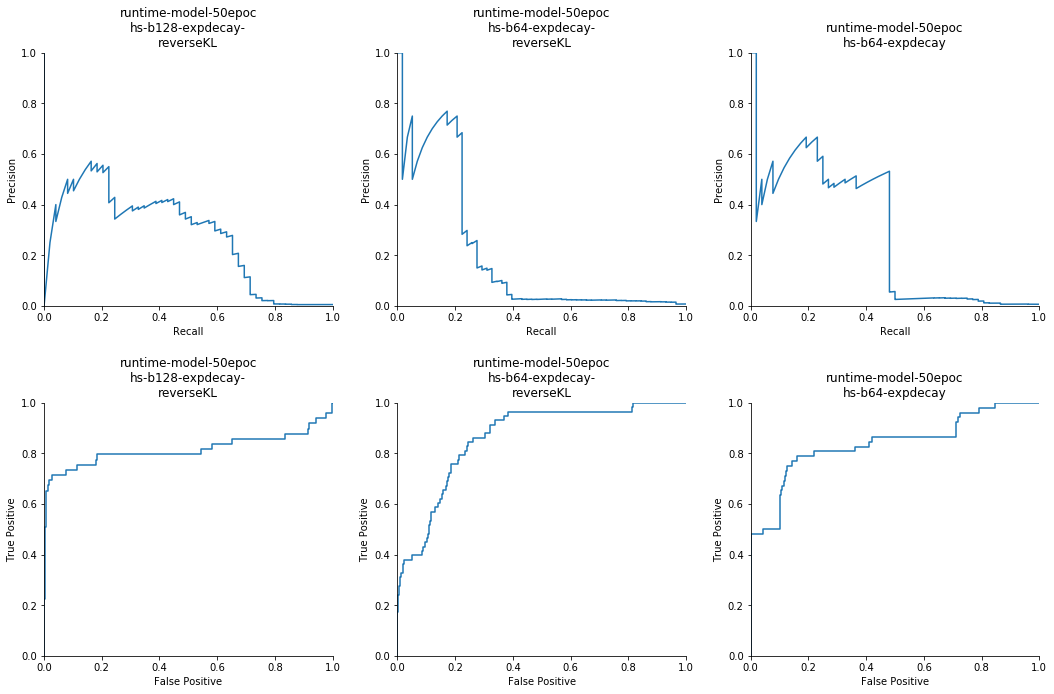

AU_PR:  [0.2699312157407083, 0.19669511474092227, 0.2737230170827529]
AU_ROC:  [0.814931942026132, 0.8608342177734308, 0.83832853917293]


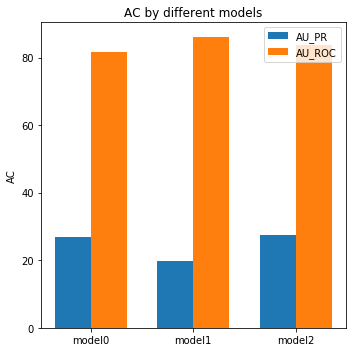

In [35]:
aupr_list, auroc_list, class_dist = plot_pr_roc_curve_misclassify(models, 'eval', 'confidence')
plot_aupr_auroc(aupr_list, auroc_list)

[[  49 9951]
 [  58 9942]
 [  52 9948]]


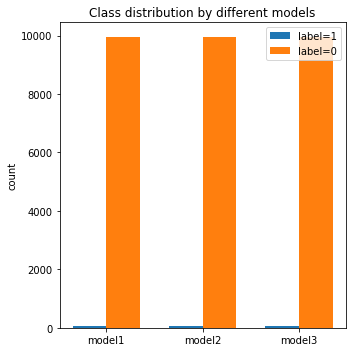

In [10]:
class_dist = np.asarray(class_dist)
print(class_dist)
x = np.arange(len(models)) 
width = 0.35

rcParams['figure.figsize'] = 5, 5
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, class_dist[:,0], width, label='label=1')
rects2 = ax.bar(x + width/2, class_dist[:,1], width, label='label=0')

ax.set_ylabel('count')
ax.set_title('Class distribution by different models')
ax.set_xticks(x)
ax.set_xticklabels(['model1','model2','model3'])
ax.legend()

fig.tight_layout()
plt.show()

In [11]:
# Model 2 (runtime-model-50epochs-b64-expdecay-reverseKL)' classification accuracy and other results
with open(f'{models[1]}/eval/results.txt', 'r') as f:
    print(f.read())

Classification Error: 0.6 
NLL: 0.75 
AUPR using confidence: 19.7
AUPR using entropy_of_expected: 16.6
AUPR using expected_entropy: 5.4
AUPR using mutual_information: 18.4
AUPR using EPKL: 6.6
AUPR using differential_entropy: 4.3
AUROC using confidence: 86.1
AUROC using entropy_of_expected: 85.3
AUROC using expected_entropy: 83.4
AUROC using mutual_information: 61.2
AUROC using EPKL: 28.4
AUROC using differential_entropy: 82.3
ECE: 51.59
MCE: 62.03
Rejection Ratio using confidence: 71.7
Rejection Ratio using entropy_of_expected: 70.1
Rejection Ratio using expected_entropy: 66.2
Rejection Ratio using mutual_information: 21.0
Rejection Ratio using EPKL: -45.7
Rejection Ratio using differential_entropy: 64.1



## FGSM Attack on confidence - test data

In [41]:
model_dir="runtime-model-50epochs-b64-expdecay-reverseKL"
attack_dir="FGSM-attack-1586523207"

In [21]:
def plot_adv_samples(model_dir, attack_dir, epsilon, plots_dir='vis', known_misclassified_indices=[]):
    
    target_epsilon_dir = os.path.join(model_dir, attack_dir, f"e{epsilon}-attack")
    probs = np.loadtxt(f"{target_epsilon_dir}/probs.txt")
    labels = np.loadtxt(f"{target_epsilon_dir}/labels.txt")
    new_confidence = np.loadtxt(f"{target_epsilon_dir}/confidence.txt") # current confidence on attack images
    
    # misclassified samples under attack
    preds = np.argmax(probs, axis=1)
    misclassification = np.asarray(preds != labels, dtype=np.int32)
    misclassified = np.argwhere(misclassification == 1)
    print("# Misclassified samples under attack: ", misclassified.size)
    
    # real adversarial samples - original model correctly classified them, but now misclassified!
    old_probs = np.loadtxt(f"{model_dir}/eval/probs.txt") # prob dist outputed by model on non-perturbed images.
    old_confidence = np.loadtxt(f"{model_dir}/eval/confidence.txt") # confidence of all attack_images from normal eval phase.
        
    old_preds = np.argmax(old_probs, axis=1)
    correct_classifications = np.asarray(old_preds == labels, dtype=np.int32)
    correct_classified_indices = np.argwhere(correct_classifications == 1)
    
    misclassified = np.intersect1d(misclassified, correct_classified_indices)
    print("# Real adversarial samples under attack: ", misclassified.size)
    
    if len(known_misclassified_indices) > 0: # reduce to already known indices
        misclassified = np.intersect1d(known_misclassified_indices,misclassified)
    
    # create a separate dir to store all visualizations
    os.makedirs(os.path.join(target_epsilon_dir, plots_dir))

    # first plot
    figure, axes = plt.subplots(nrows = 10,ncols=3, figsize=(15,15))
    figure.subplots_adjust(hspace=0.5, wspace=0.5)
    
    for i, index in enumerate(misclassified):
        if index.ndim > 0:
            index = index[0]
        ri = i%10

        # org image
        axis = axes[ri][0]
        img = Image.open(f"{model_dir}/{attack_dir}/org-images/{index}.png")
        axis.set_title(f"index: {index}, label: {int(labels[index])}, confidence: {np.round(old_confidence[index],3)}", pad=2)
        #hide all spines
        axis.axis("off")
        axis.imshow(img, cmap="gray")

        # adv image
        axis = axes[ri][1]
        img = Image.open(f"{target_epsilon_dir}/adv-images/{index}.png")
        axis.set_title(f"label: {preds[index]}, confidence: {np.round(new_confidence[index],3)}", pad=2)
        #hide all spines
        axis.axis("off")
        axis.imshow(img, cmap="gray")

        # change in prob dist (bar plot)
        axis = axes[ri][2]
        class_labels = np.arange(10)
        width = 0.2
        rects1 = axis.bar(class_labels - width/2, old_probs[index,:], width, label='Org')
        rects2 = axis.bar(class_labels + width/2, probs[index,:], width, label='Adv')
        axis.set_xticks(class_labels)
        axis.set_xticklabels(class_labels)
        axis.legend()
        
        if (i>0 and (i+1)% 10 == 0) or i == (misclassified.size-1): # batch every 10 sample into a single image
            plt.savefig(os.path.join(target_epsilon_dir, plots_dir, f"result_vis_{i+1}.png"), bbox_inches='tight')
            plt.close()
        
        if i>0 and (i+1)% 10 == 0 and i != (misclassified.size-1):
            figure, axes = plt.subplots(nrows = 10,ncols=3, figsize=(15,15))
            figure.subplots_adjust(hspace=0.5, wspace=0.5)

    return misclassified.size

In [19]:
def create_vis_plots(model_dir, attack_dir, epsilon, plots_dir='vis', misclassified_indices=[]):
    # all images are saved in 'vis' directory under attack folder
    misclassified_samples = plot_adv_samples(model_dir, attack_dir, epsilon, plots_dir, misclassified_indices)

    last_batch = misclassified_samples - (misclassified_samples%10)
    fig, axis = plt.subplots(figsize=(25,25))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    axis.axis("off")
    axis.imshow(Image.open(f"{model_dir}/{attack_dir}/e{epsilon}-attack/vis/result_vis_{last_batch}.png")) # prints the last but one batch
    plt.show()

# Misclassified samples under attack:  166
# Real adversarial samples under attack:  149


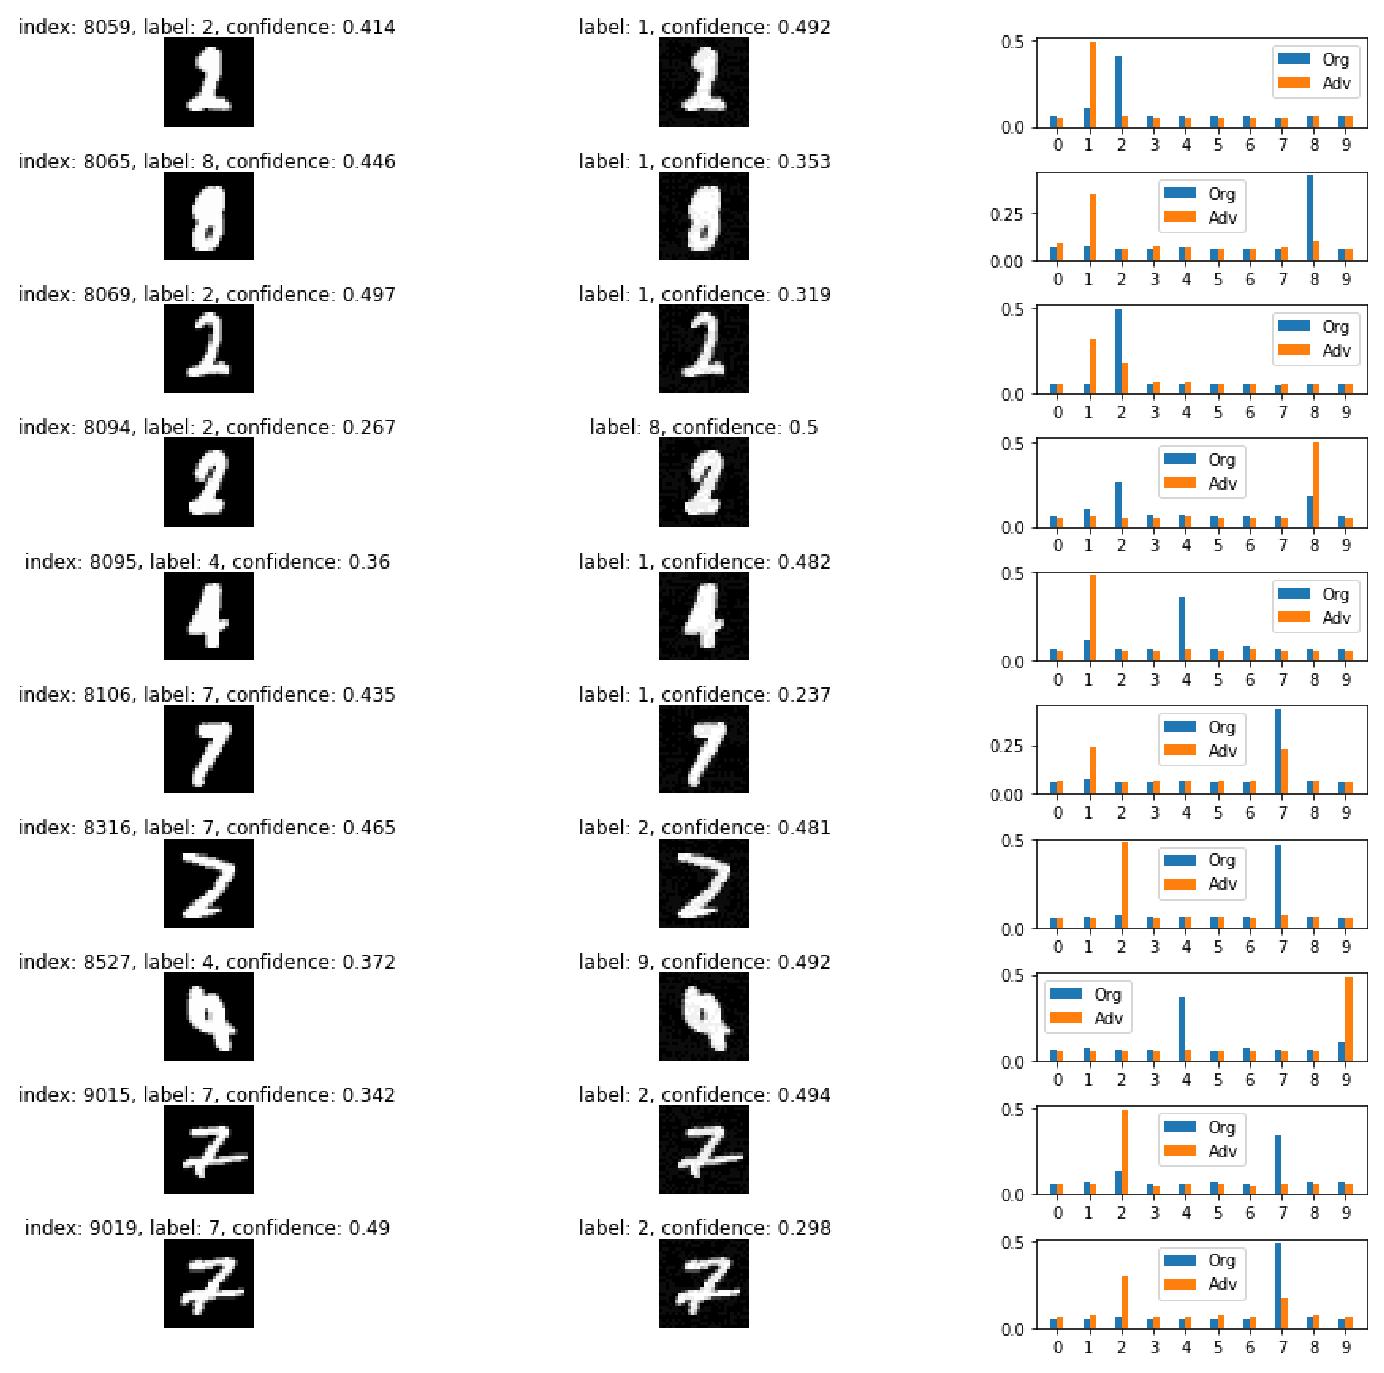

In [20]:
create_vis_plots(model_dir, attack_dir, 0.1)

# Misclassified samples under attack:  1966
# Real adversarial samples under attack:  1950


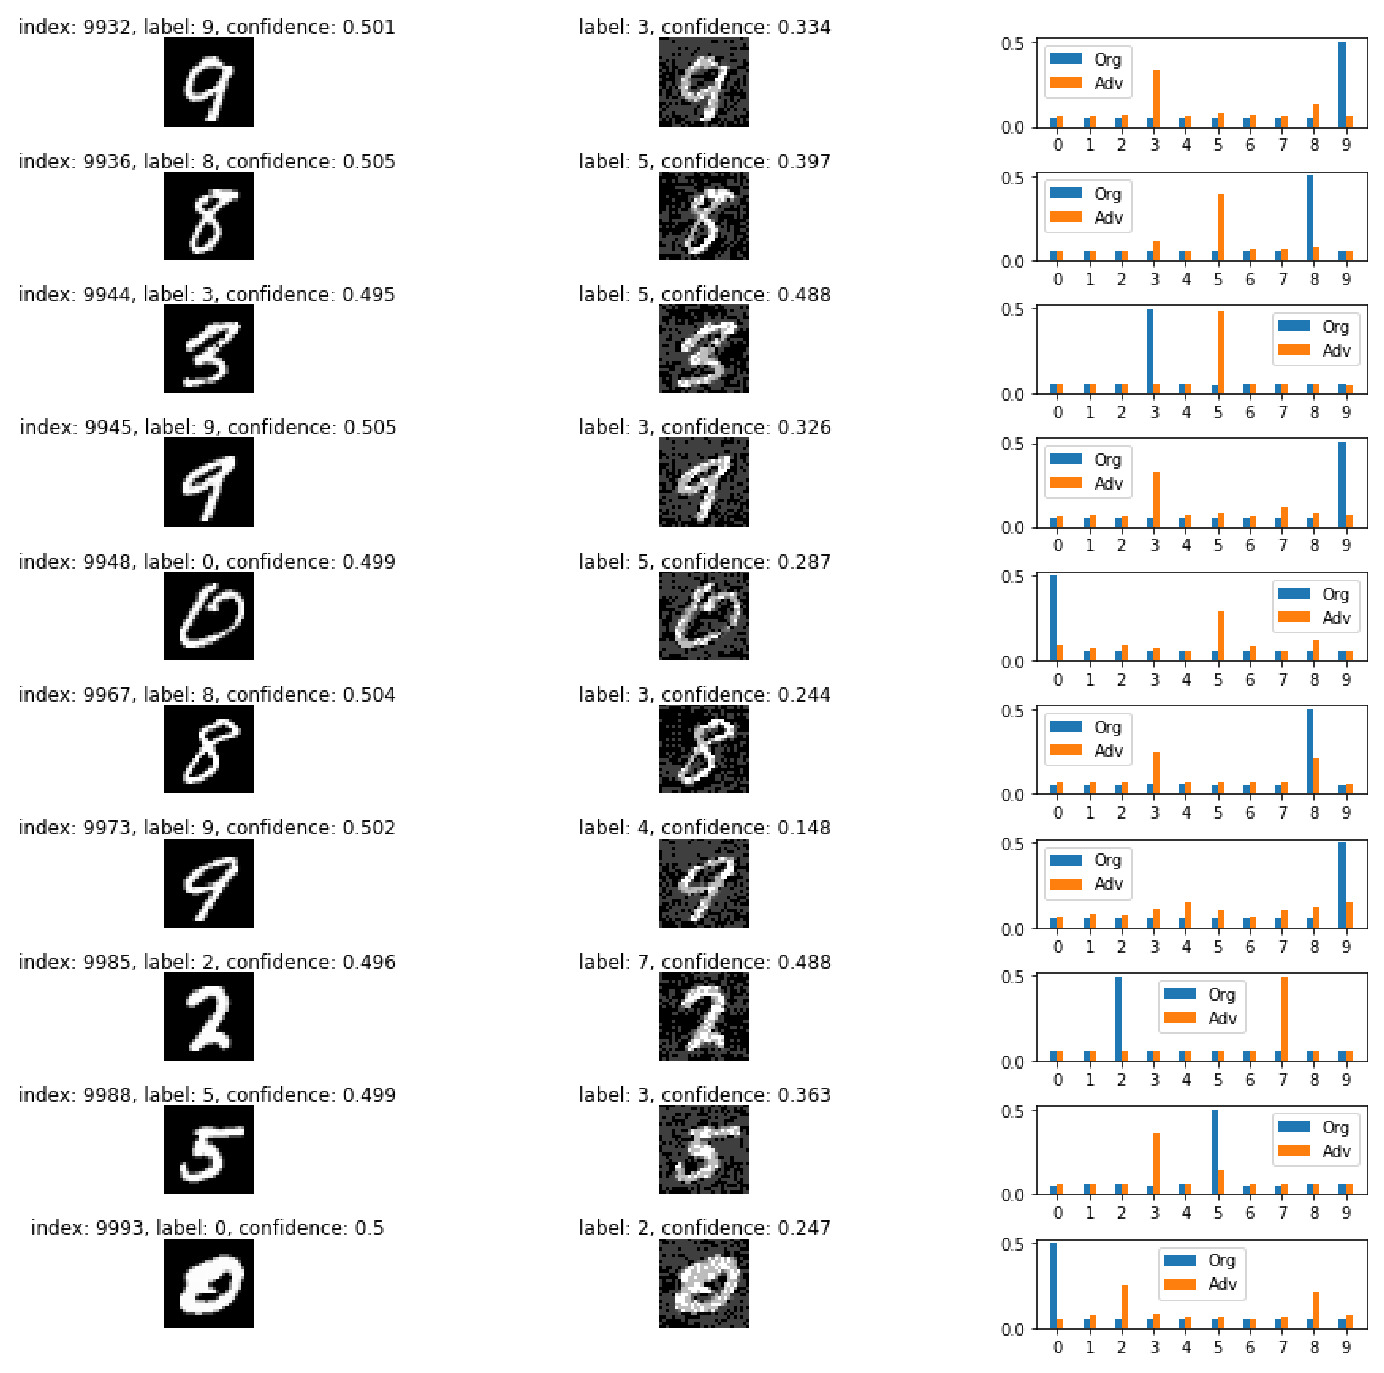

In [22]:
create_vis_plots(model_dir, attack_dir, 0.5)

### Epsilon vs Adversarial success rate curve

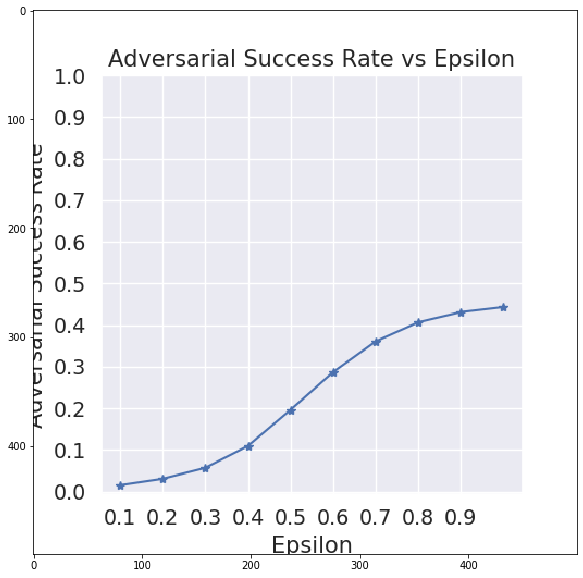

In [24]:
# sample epsilon curve
img = Image.open(f"{model_dir}/{attack_dir}/epsilon-curve.png")
plt.figure(figsize = (10,10))
plt.imshow(img)

In [79]:
# strongly misclassified images
plot_adv_samples(model_dir, attack_dir, 0.5, plots_dir="chosen-ex", misclassified_indices=[12,35,76,95,132,157,179,258,676,2155])

# Misclassified samples:  10


10

In [80]:
# weakly misclassified images
plot_adv_samples(model_dir, attack_dir, 0.5, plots_dir="chosen-ex-weak", misclassified_indices=[9, 18,1447,1427,1397,1395,1182,1119,1705,2239])

# Misclassified samples:  10


10

### Model evaluation of "test set" vs "perturbed test set" on Misclassification task

eval model: runtime-model-50epochs-b64-expdecay-reverseKL


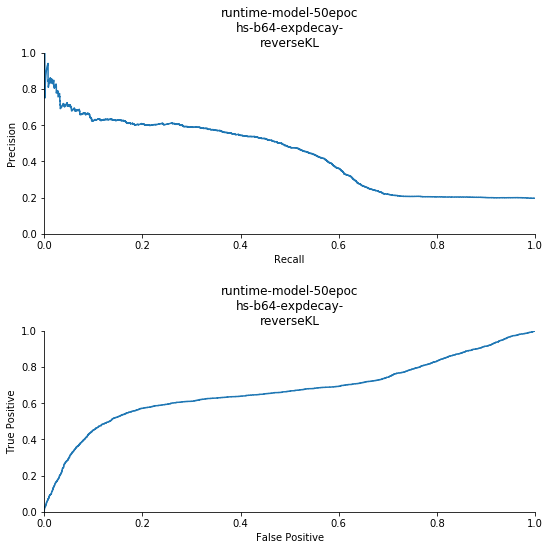

AU_PR:  [0.4361215537898255]
AU_ROC:  [0.6690156610600269]


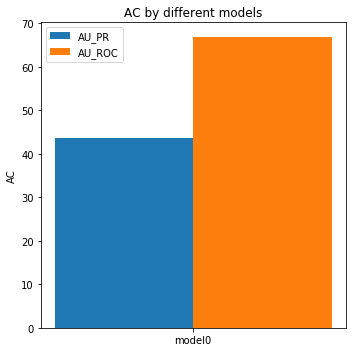

In [42]:
# model under attack
rcParams['figure.figsize'] = 5, 5
aupr_list, auroc_list, class_dist = plot_pr_roc_curve_misclassify([model_dir], f'{attack_dir}/e0.5-attack', 'confidence', fig_size=(8,8))
plot_aupr_auroc(aupr_list, auroc_list)

eval model: runtime-model-50epochs-b64-expdecay-reverseKL


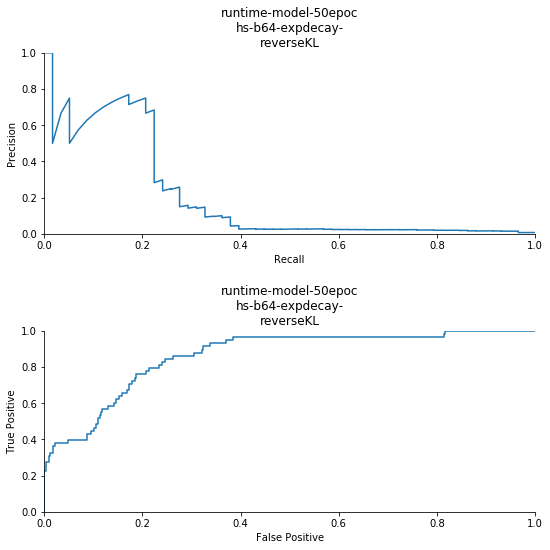

AU_PR:  [0.19669511474092227]
AU_ROC:  [0.8608342177734308]


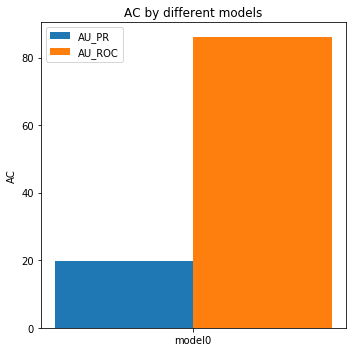

In [38]:
# original model for entire testset (already evaluated before)
aupr_list, auroc_list, class_dist = plot_pr_roc_curve_misclassify(['runtime-model-50epochs-b64-expdecay-reverseKL'], 'eval', 'confidence', fig_size=(8,8))
plot_aupr_auroc(aupr_list, auroc_list)

Results:
    
1) AUPR has increased from  19.6 to 43.6. (model under attack predicts more misclassifications than earlier, more positive class samples, so PR curve will improve under attack)
    
2) AUROC has declined from 86.08 to 66.9 (model under attack predicts more misclassifications than what it should as per the test data, hence ROC curve will degrade under attack)


## PGD Attack on confidence - test data

In [43]:
model_dir='runtime-model-50epochs-b64-expdecay-reverseKL'
attack_dir='PGD-attack-1586522269'

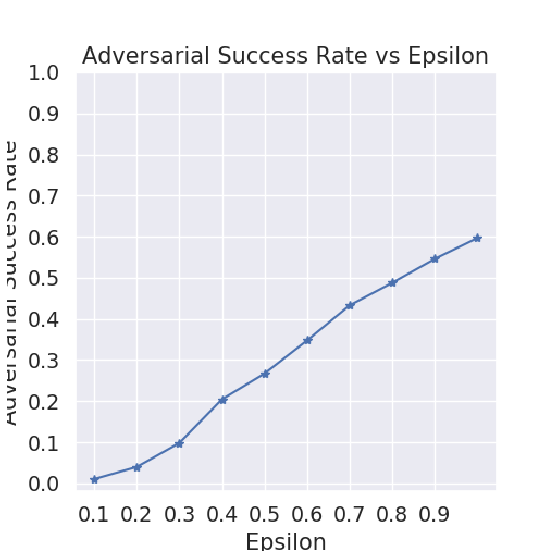

In [29]:
# sample epsilon curve
img = Image.open(f"{model_dir}/{attack_dir}/epsilon-curve.png")
plt.figure(figsize = (10,10))
plt.axis("off")
plt.imshow(img)

# Misclassified samples under attack:  1002
# Real adversarial samples under attack:  976


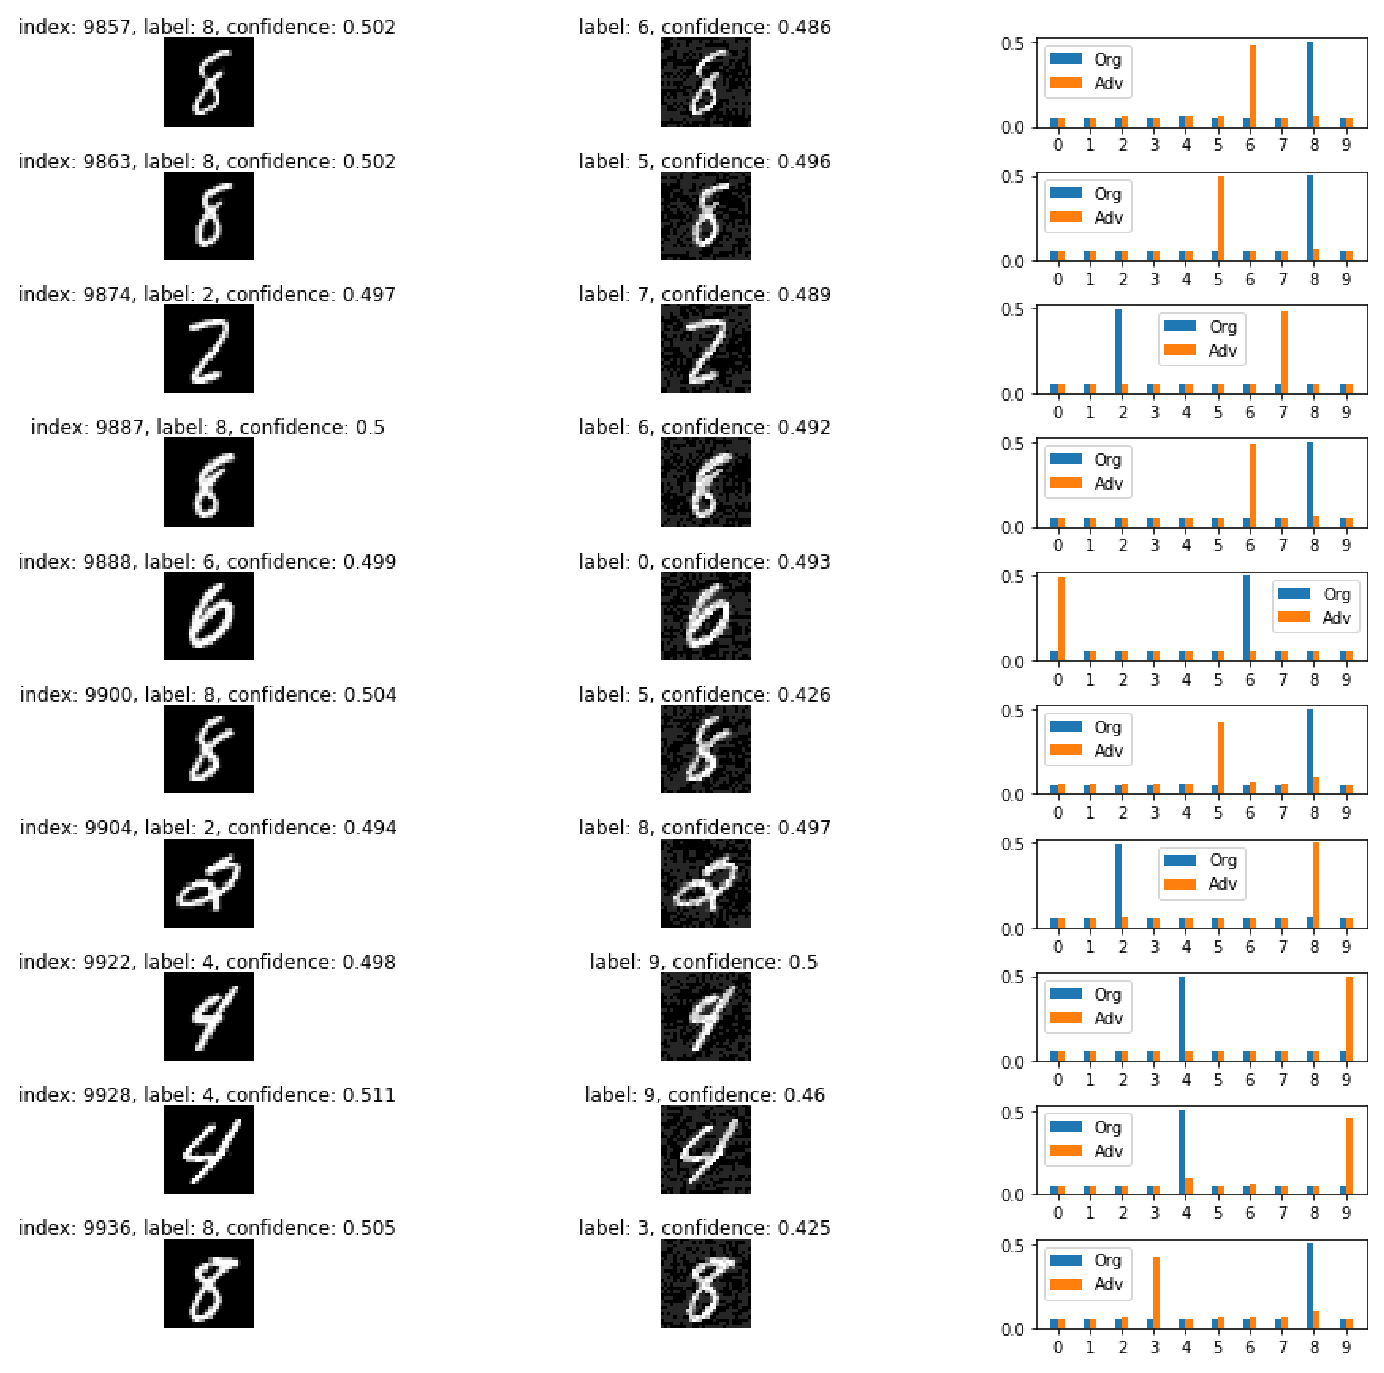

In [30]:
create_vis_plots(model_dir, attack_dir, 0.3)

### Model evaluation of "test set" vs "perturbed test set" on Misclassification task

eval model: runtime-model-50epochs-b64-expdecay-reverseKL


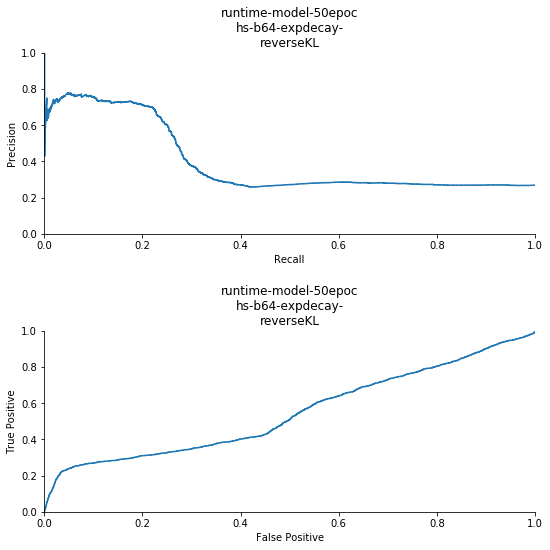

AU_PR:  [0.3997410872887912]
AU_ROC:  [0.547595106341968]


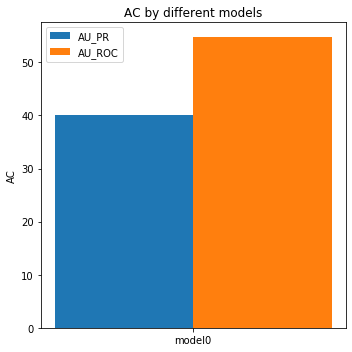

In [44]:
# model under attack
rcParams['figure.figsize'] = 5, 5
aupr_list, auroc_list, class_dist = plot_pr_roc_curve_misclassify([model_dir], f'{attack_dir}/e0.5-attack', 'confidence',fig_size=(8,8))
plot_aupr_auroc(aupr_list, auroc_list)

Results:
    
PGD proves to be a better adversary than FGSM, as ROC curve for the model under attack is brought down to almost a random classifier.

1) AUPR has increased from  19.6 to 39.9. (model under attack predicts more misclassifications than earlier, more positive class samples, so PR curve will improve under attack)

2) AUROC has declined from 86.08 to 54.7 (model under attack predicts more misclassifications than what it should as per the test data, hence ROC curve will degrade under attack)
